In [2]:
#-*-coding:utf-8-*-
import os
import random # Analysis
import datetime as dt # Analysis
import numpy as np # Analysis
import pandas as pd # Analysis
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore') # ignore warnings
# datafarme 보여주는 범위 설정

pd.options.display.max_columns=1000
pd.options.display.max_rows=200
pd.options.display.float_format = '{:.5f}'.format


df = {}

for i in range(2010, 2022):
    df[i] = pd.read_csv("../data/csv_in_" + str(i) + ".csv")
    df[i].drop(labels=df[i][df[i]['아내지역코드'] == 80].index, inplace=True)
    df[i].drop(labels=df[i][df[i]['남편지역코드'] == 80].index, inplace=True)
    df[i].drop(labels=df[i][df[i]['아내직업코드'] == 99].index, inplace=True)
    df[i].drop(labels=df[i][df[i]['남편직업코드'] == 99].index, inplace=True)
    df[i].drop(labels=df[i][df[i]['아내결혼코드'] == 9].index, inplace=True)
    df[i].drop(labels=df[i][df[i]['남편결혼코드'] == 9].index, inplace=True)
    df[i].drop(labels=df[i][df[i]['남편교육코드'] == 9].index, inplace=True)
    df[i].drop(labels=df[i][df[i]['아내교육코드'] == 9].index, inplace=True)
for i in range(2010, 2021):
    df[i].drop(labels=df[i][df[i]['남편국적구분코드'] == 9].index, inplace=True)
    df[i].drop(labels=df[i][df[i]['아내국적구분코드'] == 9].index, inplace=True)

mandic = {1:10015,2:5011,3:4833,5:3325.5,6:2582,7:3510,8:3539,9:2494,13:0}
womandic = {1:8024,2:3136,3:3256,5:2119,6:2060,7:2156,8:2795,9:1897,13:0}

for i in range(2010,2022):
    df[i]['남편소득수준'] = df[i]['남편직업코드']
    df[i]['아내소득수준'] = df[i]['아내직업코드']
    
    for j in mandic.keys():
        df[i]['남편소득수준'].replace(j,mandic[j], inplace=True)
        df[i]['아내소득수준'].replace(j,womandic[j], inplace=True)
        
#기본전처리. 
#연도삭제
plt.rcParams['font.family'] = 'HYGraphic-Medium' # 깨짐방지
#교육수준 통합 필요.


# 3 -> 중졸 이히
# 4 -> 고졸
# 5 -> 대졸
# 6 -> 대학원졸
for i in range(2010, 2022):
    df[i].drop(df[i][df[i]['남편교육코드'] >= 7].index, inplace=True)
    df[i].loc[df[i]["남편교육코드"] == 1, "남편교육코드"] = 3
    df[i].loc[df[i]["남편교육코드"] == 2, "남편교육코드"] = 3


In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import statsmodels.api as sm

In [4]:
dic = {1:0.038,2:0.123,3:0.2,4:0.285,5:0.367,
6:0.452,7:0.534,8:0.619,9:0.704,10:0.786,11:0.871,12:0.953}
for i in range(2010,2022):
    for j in dic.keys():
        df[i].loc[df[i]['실제결혼월'] == j,'남편출생년도'] = ((df[i]['실제결혼연도']+dic[j])-df[i]['남편연령']).apply(int)
        df[i].loc[df[i]['실제결혼월'] == j,'아내출생년도'] = ((df[i]['실제결혼연도']+dic[j])-df[i]['아내연령']).apply(int)


In [5]:
for year in range(2010,2022):
    # 소득  (연속)
    # 소득 차이 (연속)
    # 여성결혼연령 (연속)
    # 연상혼
    df[year].loc[round(df[year]['남편연령']) < round(df[year]['아내연령']), "강혼여부이전기준"] = 1
    df[year].loc[round(df[year]['남편연령']) >= round(df[year]['아내연령']), "강혼여부이전기준"] = 0
    df[year].loc[df[year]['남편출생년도'] > df[year]['아내출생년도'], "강혼여부"] = 1
    df[year].loc[df[year]['남편출생년도'] <= df[year]['아내출생년도'], "강혼여부"] = 0
    df[year].loc[df[year]['남편출생년도'] == df[year]['아내출생년도'], "동갑혼여부"] = 1
    df[year].loc[df[year]['남편출생년도'] != df[year]['아내출생년도'], "동갑혼여부"] = 0
    df[year].loc[df[year]['남편출생년도'] < df[year]['아내출생년도'], "연하혼여부"] = 1
    df[year].loc[df[year]['남편출생년도'] >= df[year]['아내출생년도'], "연하혼여부"] = 0

    # 아내 대도시
    df[year].loc[df[year]['아내지역코드'].isin([11, 21, 22, 23, 24, 25]), 
    "아내대도시여부"] = 1
    df[year].loc[~df[year]['아내지역코드'].isin([11, 21, 22, 23, 24, 25]), 
    "아내대도시여부"] = 0

    # 남편 대도시
    df[year].loc[df[year]['남편지역코드'].isin([11, 21, 22, 23, 24, 25]),
    "남편대도시여부"] = 1
    df[year].loc[~df[year]['남편지역코드'].isin([11, 21, 22, 23, 24, 25]),
    "남편대도시여부"] = 0
    df[year].loc[df[year]['남편지역코드'].isin([11,23,31]),
    "남편수도권여부"] = 1
    df[year].loc[~df[year]['남편지역코드'].isin([11,23,31]),
    "남편수도권여부"] = 0
    df[year].loc[df[year]['아내지역코드'].isin([11,23,31]),
    "아내수도권여부"] = 1
    df[year].loc[~df[year]['아내지역코드'].isin([11,23,31]),
    "아내수도권여부"] = 0
    # 남자 결혼 종류

    # 여자 결혼 종류

    # 아내 재혼 여부
    df[year].loc[df[year]['아내결혼코드'] == 1,
    "아내재혼여부"] = 0
    df[year].loc[df[year]['아내결혼코드'] != 1,
    "아내재혼여부"]= 1

    # 남편 재혼 여부
    df[year].loc[df[year]['남편결혼코드'] == 1, 
    "남편재혼여부"] = 0
    df[year].loc[df[year]['남편결혼코드'] != 1, 
    "남편재혼여부"]= 1

    # 결혼 종류 차이 여부
    df[year].loc[df[year]['남편재혼여부'] == df[year]['아내재혼여부'], 
    "결혼종류차이여부"] = 1
    df[year].loc[df[year]['남편재혼여부'] != df[year]['아내재혼여부'],
    "결혼종류차이여부"]= 0

    # 강혼여부 여부
    df[year].loc[df[year]['아내교육코드'] > df[year]['남편교육코드'],
    "강혼여부"] = 1
    df[year].loc[~(df[year]['아내교육코드'] > df[year]['남편교육코드']),
    "강혼여부"] = 0

    # 동질혼 여부
    df[year].loc[df[year]['아내교육코드'] == df[year]['남편교육코드'],
    "동질혼여부"] = 1
    df[year].loc[df[year]['아내교육코드'] != df[year]['남편교육코드'],
    "동질혼여부"] = 0

    # 승혼 여부
    df[year].loc[df[year]['아내교육코드'] < df[year]['남편교육코드'],
    "승혼여부"] = 1
    df[year].loc[~(df[year]['아내교육코드'] < df[year]['남편교육코드']),
    "승혼여부"] = 0

    # 소득 차
    df[year]['소득차'] = df[year]['아내소득수준'] - df[year]['남편소득수준']

    # 소득차 카테고리화
    df[year].loc[df[year]['소득차'] > 0, '소득차범주'] = 1
    df[year].loc[df[year]['소득차'] == 0, '소득차범주'] = 2
    df[year].loc[df[year]['소득차'] < 0, '소득차범주'] = 3
    

    df[year]['아내연령제곱'] = df[year]['아내연령'] ** 2
    df[year]['남편연령제곱'] = df[year]['남편연령'] ** 2

    # 아내 무직 여부
    df[year].loc[df[year]['아내직업코드'] == 13, "아내무직여부"] = 1
    df[year].loc[df[year]['아내직업코드'] != 13, "아내무직여부"] = 0

    # 남편 무직 여부
    df[year].loc[df[year]['남편직업코드'] == 13, "남편무직여부"] = 1
    df[year].loc[df[year]['남편직업코드'] != 13, "남편무직여부"] = 0

    df[year].loc[df[year]['남편지역코드'] == df[year]['아내지역코드'], "동일지역여부"] = 1
    df[year].loc[df[year]['남편지역코드'] != df[year]['아내지역코드'], "동일지역여부"] = 0

    df[year].loc[df[year]['아내교육코드'] == 3, "아내중졸여부"] = 1
    df[year].loc[df[year]['아내교육코드'] != 3, "아내중졸여부"] = 0
    df[year].loc[df[year]['남편교육코드'] == 3, "남편중졸여부"] = 1
    df[year].loc[df[year]['남편교육코드'] != 3, "남편중졸여부"] = 0

    df[year].loc[df[year]['아내교육코드'] == 4, "아내고졸여부"] = 1
    df[year].loc[df[year]['아내교육코드'] != 4, "아내고졸여부"] = 0
    df[year].loc[df[year]['남편교육코드'] == 4, "남편고졸여부"] = 1
    df[year].loc[df[year]['남편교육코드'] != 4, "남편고졸여부"] = 0

    df[year].loc[df[year]['아내교육코드'] == 5, "아내대졸여부"] = 1
    df[year].loc[df[year]['아내교육코드'] !=5, "아내대졸여부"] = 0
    df[year].loc[df[year]['남편교육코드'] == 5, "남편대졸여부"] = 1
    df[year].loc[df[year]['남편교육코드'] !=5, "남편대졸여부"] = 0

    df[year].loc[df[year]['남편교육코드'] == 6, "남편대학원졸여부"] = 1
    df[year].loc[df[year]['남편교육코드'] !=6, "남편대학원졸여부"] = 0
    df[year].loc[df[year]['아내교육코드'] == 6, "아내대학원졸여부"] = 1
    df[year].loc[df[year]['아내교육코드'] !=6, "아내대학원졸여부"] = 0

    df[year].loc[df[year]['남편교육코드'] ==df[year]['아내교육코드'] , "동질혼여부"] = 1
    df[year].loc[df[year]['남편교육코드'] !=df[year]['아내교육코드'] , "동질혼여부"] = 0
    

for year in range(2010,2022):
    df[year]['아내국제결혼여부'] = 0
    df[year].loc[((df[year]['아내국적구분코드']>= 2)&(df[year]['신고연도']!=2021)), "아내국제결혼여부"] = 1
    df[year]['남편국제결혼여부'] = 0
    df[year].loc[((df[year]['남편국적구분코드']>=2)&(df[year]['신고연도']!=2021)), "남편국제결혼여부"] = 1
    df[year].loc[((df[year]['아내지역코드']>80)&(df[year]['신고연도'] == 2021)), "아내국제결혼여부"] = 1
    df[year].loc[(~(df[year]['아내지역코드']>80)&(df[year]['신고연도'] == 2021)), "아내국제결혼여부"] = 0
    df[year].loc[((df[year]['남편지역코드']>80)&(df[year]['신고연도'] == 2021)), "남편국제결혼여부"] = 1
    df[year].loc[(~(df[year]['남편지역코드']>80)&(df[year]['신고연도'] == 2021)), "남편국제결혼여부"] = 0

In [7]:
df_from_2014_to_2021 = df[2021].append(df[2020]).append(df[2019]).append(df[2018]).append(df[2017]).append(df[2016]).append(df[2015]).append(df[2014])
df_from_2014_to_2020 = df[2020].append(df[2019]).append(df[2018]).append(df[2017]).append(df[2016]).append(df[2015]).append(df[2014])

In [8]:
df_from_2014_to_2021.loc[df_from_2014_to_2021['실제결혼연도'] == 2015, "15년여부"] = 1
df_from_2014_to_2021.loc[df_from_2014_to_2021['실제결혼연도'] != 2015, "15년여부"] = 0
df_from_2014_to_2021.loc[df_from_2014_to_2021['실제결혼연도'] == 2016, "16년여부"] = 1
df_from_2014_to_2021.loc[df_from_2014_to_2021['실제결혼연도'] != 2016, "16년여부"] = 0
df_from_2014_to_2021.loc[df_from_2014_to_2021['실제결혼연도'] == 2017, "17년여부"] = 1
df_from_2014_to_2021.loc[df_from_2014_to_2021['실제결혼연도'] != 2017, "17년여부"] = 0
df_from_2014_to_2021.loc[df_from_2014_to_2021['실제결혼연도'] == 2018, "18년여부"] = 1
df_from_2014_to_2021.loc[df_from_2014_to_2021['실제결혼연도'] != 2018, "18년여부"] = 0
df_from_2014_to_2021.loc[df_from_2014_to_2021['실제결혼연도'] == 2019, "19년여부"] = 1
df_from_2014_to_2021.loc[df_from_2014_to_2021['실제결혼연도'] != 2019, "19년여부"] = 0
df_from_2014_to_2021.loc[df_from_2014_to_2021['실제결혼연도'] == 2020, "20년여부"] = 1
df_from_2014_to_2021.loc[df_from_2014_to_2021['실제결혼연도'] != 2020, "20년여부"] = 0
df_from_2014_to_2021.loc[df_from_2014_to_2021['실제결혼연도'] == 2021, "21년여부"] = 1
df_from_2014_to_2021.loc[df_from_2014_to_2021['실제결혼연도'] != 2021, "21년여부"] = 0

df_from_2014_to_2021.loc[df_from_2014_to_2021['실제결혼연도'] >=2020, "코로나여부"] = 1
df_from_2014_to_2021.loc[df_from_2014_to_2021['실제결혼연도'] <2020, "코로나여부"] = 0

df_from_2014_to_2021.drop(labels=df_from_2014_to_2021[df_from_2014_to_2021['아내결혼코드'] == 2].index, inplace=True)
df_from_2014_to_2021.drop(labels=df_from_2014_to_2021[df_from_2014_to_2021['남편결혼코드'] == 2].index, inplace=True)

df_from_2014_to_2020.loc[df_from_2014_to_2020['실제결혼연도'] == 2015, "15년여부"] = 1
df_from_2014_to_2020.loc[df_from_2014_to_2020['실제결혼연도'] != 2015, "15년여부"] = 0
df_from_2014_to_2020.loc[df_from_2014_to_2020['실제결혼연도'] == 2016, "16년여부"] = 1
df_from_2014_to_2020.loc[df_from_2014_to_2020['실제결혼연도'] != 2016, "16년여부"] = 0
df_from_2014_to_2020.loc[df_from_2014_to_2020['실제결혼연도'] == 2017, "17년여부"] = 1
df_from_2014_to_2020.loc[df_from_2014_to_2020['실제결혼연도'] != 2017, "17년여부"] = 0
df_from_2014_to_2020.loc[df_from_2014_to_2020['실제결혼연도'] == 2018, "18년여부"] = 1
df_from_2014_to_2020.loc[df_from_2014_to_2020['실제결혼연도'] != 2018, "18년여부"] = 0
df_from_2014_to_2020.loc[df_from_2014_to_2020['실제결혼연도'] == 2019, "19년여부"] = 1
df_from_2014_to_2020.loc[df_from_2014_to_2020['실제결혼연도'] != 2019, "19년여부"] = 0
df_from_2014_to_2020.loc[df_from_2014_to_2020['실제결혼연도'] == 2020, "20년여부"] = 1
df_from_2014_to_2020.loc[df_from_2014_to_2020['실제결혼연도'] != 2020, "20년여부"] = 0

df_from_2014_to_2020.drop(labels=df_from_2014_to_2020[df_from_2014_to_2020['아내결혼코드'] == 2].index, inplace=True)
df_from_2014_to_2020.drop(labels=df_from_2014_to_2020[df_from_2014_to_2020['남편결혼코드'] == 2].index, inplace=True)

df_from_2014_to_2020.loc[df_from_2014_to_2020['실제결혼연도'] >=2020, "코로나여부"] = 1
df_from_2014_to_2020.loc[df_from_2014_to_2020['실제결혼연도'] <2020, "코로나여부"] = 0

In [9]:
#아내 출생코호트

min = 1970
step = 5
for y in range (1970, 2000, step):
    df_from_2014_to_2021.loc[df_from_2014_to_2021['아내출생년도'].between(y, y + 5), "아내코호트"] = f"{y} to {y + 5}" 

for y in range (1970, 2000, step):
    df_from_2014_to_2021.loc[df_from_2014_to_2021['아내출생년도'].between(y, y + 5), "아내코호트"] = f"{y} to {y + 5}" 

df_from_2014_to_2021.loc[df_from_2014_to_2021['아내출생년도']<1970,'아내코호트'] = '1970 to 1975 (아내)'
df_from_2014_to_2021.loc[df_from_2014_to_2021['아내출생년도']>=2000,'아내코호트'] = '1995 to 2000 (아내)'

for code in df_from_2014_to_2021['아내코호트'].unique():
    df_from_2014_to_2021.loc[df_from_2014_to_2021['아내코호트'] == code, str(code) + " (아내)"] = 1
    df_from_2014_to_2021.loc[df_from_2014_to_2021['아내코호트'] != code, str(code) + " (아내)"] = 0



#남편 출생코호트

min = 1970
step = 5

for y in range (1970, 2000, step):
    df_from_2014_to_2021.loc[df_from_2014_to_2021['남편출생년도'].between(y, y + 5), "남편코호트"] = f"{y} to {y + 5}" 

df_from_2014_to_2021.loc[df_from_2014_to_2021['남편출생년도']<1970,'남편코호트'] = '1970 to 1975 (남편)'
df_from_2014_to_2021.loc[df_from_2014_to_2021['남편출생년도']>=2000,'남편코호트'] = '1995 to 2000 (남편)'

for code in df_from_2014_to_2021['남편코호트'].unique():
    df_from_2014_to_2021.loc[df_from_2014_to_2021['남편코호트'] == code, str(code) + " (남편)"] = 1
    df_from_2014_to_2021.loc[df_from_2014_to_2021['남편코호트'] != code, str(code) + " (남편)"] = 0



In [10]:
df_from_2014_to_2021.loc[(df_from_2014_to_2021['실제결혼연도'] == 2014)|(df_from_2014_to_2021['실제결혼연도'] == 2015), "시점1"] = 1
df_from_2014_to_2021.loc[(df_from_2014_to_2021['실제결혼연도'] != 2014)&(df_from_2014_to_2021['실제결혼연도'] != 2015), "시점1"] = 0
df_from_2014_to_2021.loc[(df_from_2014_to_2021['실제결혼연도'] == 2016)|(df_from_2014_to_2021['실제결혼연도'] == 2017), "시점2"] = 1
df_from_2014_to_2021.loc[(df_from_2014_to_2021['실제결혼연도'] != 2016)&(df_from_2014_to_2021['실제결혼연도'] != 2017), "시점2"] = 0
df_from_2014_to_2021.loc[(df_from_2014_to_2021['실제결혼연도'] == 2018)|(df_from_2014_to_2021['실제결혼연도'] == 2019), "시점3"] = 1
df_from_2014_to_2021.loc[(df_from_2014_to_2021['실제결혼연도'] != 2018)&(df_from_2014_to_2021['실제결혼연도'] != 2019), "시점3"] = 0
df_from_2014_to_2021.loc[(df_from_2014_to_2021['실제결혼연도'] == 2020)|(df_from_2014_to_2021['실제결혼연도'] == 2021), "시점4"] = 1
df_from_2014_to_2021.loc[(df_from_2014_to_2021['실제결혼연도'] != 2020)&(df_from_2014_to_2021['실제결혼연도'] != 2021), "시점4"] = 0

In [11]:
df_from_2014_to_2021.loc[df_from_2014_to_2021['실제결혼연도'] == 2015, "15년여부"] = 1
df_from_2014_to_2021.loc[df_from_2014_to_2021['실제결혼연도'] != 2015, "15년여부"] = 0
df_from_2014_to_2021.loc[df_from_2014_to_2021['실제결혼연도'] == 2016, "16년여부"] = 1
df_from_2014_to_2021.loc[df_from_2014_to_2021['실제결혼연도'] != 2016, "16년여부"] = 0
df_from_2014_to_2021.loc[df_from_2014_to_2021['실제결혼연도'] == 2017, "17년여부"] = 1
df_from_2014_to_2021.loc[df_from_2014_to_2021['실제결혼연도'] != 2017, "17년여부"] = 0
df_from_2014_to_2021.loc[df_from_2014_to_2021['실제결혼연도'] == 2018, "18년여부"] = 1
df_from_2014_to_2021.loc[df_from_2014_to_2021['실제결혼연도'] != 2018, "18년여부"] = 0
df_from_2014_to_2021.loc[df_from_2014_to_2021['실제결혼연도'] == 2019, "19년여부"] = 1
df_from_2014_to_2021.loc[df_from_2014_to_2021['실제결혼연도'] != 2019, "19년여부"] = 0
df_from_2014_to_2021.loc[df_from_2014_to_2021['실제결혼연도'] == 2020, "20년여부"] = 1
df_from_2014_to_2021.loc[df_from_2014_to_2021['실제결혼연도'] != 2020, "20년여부"] = 0
df_from_2014_to_2021.loc[df_from_2014_to_2021['실제결혼연도'] == 2021, "21년여부"] = 1
df_from_2014_to_2021.loc[df_from_2014_to_2021['실제결혼연도'] != 2021, "21년여부"] = 0
df_from_2014_to_2021.loc[df_from_2014_to_2021['실제결혼연도'] >=2020, "코로나여부"] = 1
df_from_2014_to_2021.loc[df_from_2014_to_2021['실제결혼연도'] <2020, "코로나여부"] = 0

In [12]:
features3 = df_from_2014_to_2021[['소득차','남편수도권여부','아내수도권여부','아내고졸여부',
'동일지역여부','남편재혼여부','아내연령','아내국제결혼여부','남편국제결혼여부',
'15년여부','16년여부','17년여부','18년여부','19년여부','20년여부','21년여부']]
oldmarriage3= df_from_2014_to_2021['강혼여부']
scaler = StandardScaler()
features3= scaler.fit_transform(features3)
model = sm.Logit(oldmarriage3,features3)
results = model.fit()
print('강혼여부으로 로지스틱 회귀분석')
print(results.summary(xname = ['소득차','남편수도권여부','아내수도권여부','아내고졸여부',
'동일지역여부','남편재혼여부','아내연령','아내국제결혼여부','남편국제결혼여부',
'15년여부','16년여부','17년여부','18년여부','19년여부','20년여부','21년여부']))


Optimization terminated successfully.
         Current function value: 0.682047
         Iterations 4
강혼여부으로 로지스틱 회귀분석
                           Logit Regression Results                           
Dep. Variable:                   강혼여부   No. Observations:              1562983
Model:                          Logit   Df Residuals:                  1562967
Method:                           MLE   Df Model:                           15
Date:                Tue, 23 Aug 2022   Pseudo R-squ.:                 -0.4770
Time:                        10:52:13   Log-Likelihood:            -1.0660e+06
converged:                       True   LL-Null:                   -7.2174e+05
Covariance Type:            nonrobust   LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
소득차            0.0494      0.002     30.246      0.000       0.046       0.053
남편수도권여부     

In [13]:
from pylab import plot, show
from pylab import title, xlabel, ylabel
hypogamy_ratios = []
hypergamy_ratios = []
same_ratios = []
for i in range(2010,2022):
    hypogamy_len = len(df[i][df[i]['강혼여부'] == 1])
    hypergamy_len = len(df[i][df[i]['승혼여부'] == 1])
    same_len = len(df[i][df[i]['동질혼여부'] == 1])
    print(same_len)
    n = len(df[i])
    hypogamy_ratios.append(hypogamy_len/n)
    hypergamy_ratios.append(hypergamy_len/n)
    same_ratios.append(same_len/n)
   

209117
205461
205385
198934
193407
186275
167672
150016
141707
130381
106377
76353


### 강혼여부 관련 비율

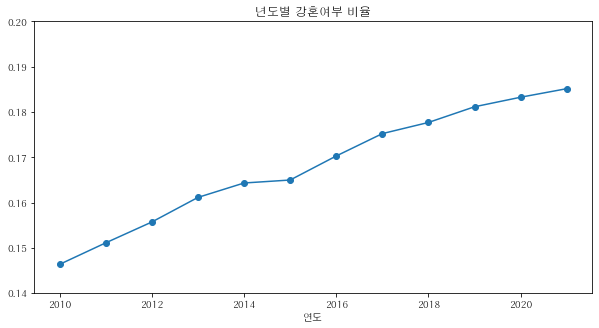

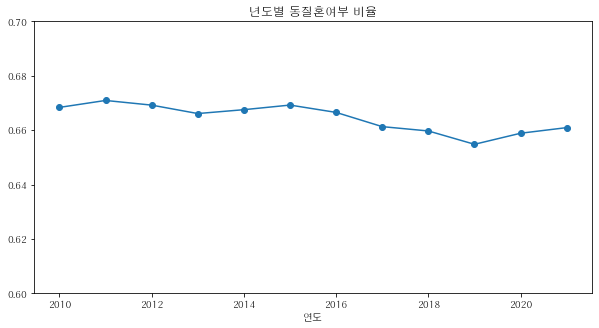

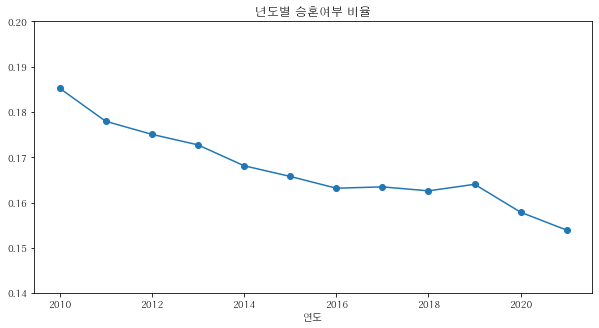

In [14]:
plt.figure(figsize=(10,5),facecolor= 'white')
title('년도별 강혼여부 비율')
xlabel('연도')
x=range(2010,2022)
y = hypogamy_ratios
plt.ylim(0.14,0.2)
plot(x, y, marker="o")
plt.show()

plt.figure(figsize=(10,5),facecolor= 'white')
title('년도별 동질혼여부 비율')
xlabel('연도')
x= range(2010,2022)
y = same_ratios
plt.ylim(0.6,0.7)
plot(x, y, marker="o")
plt.show()

plt.figure(figsize=(10,5),facecolor= 'white')
title('년도별 승혼여부 비율')
xlabel('연도')
x=range(2010,2022)
y = hypergamy_ratios
plt.ylim(0.14,0.2)
plot(x, y, marker="o")
plt.show()



In [15]:
df_from_2014_to_2021.loc[(df_from_2014_to_2021['실제결혼연도'] == 2014)|(df_from_2014_to_2021['실제결혼연도'] == 2015), "시점1"] = 1
df_from_2014_to_2021.loc[(df_from_2014_to_2021['실제결혼연도'] != 2014)&(df_from_2014_to_2021['실제결혼연도'] != 2015), "시점1"] = 0
df_from_2014_to_2021.loc[(df_from_2014_to_2021['실제결혼연도'] == 2016)|(df_from_2014_to_2021['실제결혼연도'] == 2017), "시점2"] = 1
df_from_2014_to_2021.loc[(df_from_2014_to_2021['실제결혼연도'] != 2016)&(df_from_2014_to_2021['실제결혼연도'] != 2017), "시점2"] = 0
df_from_2014_to_2021.loc[(df_from_2014_to_2021['실제결혼연도'] == 2018)|(df_from_2014_to_2021['실제결혼연도'] == 2019), "시점3"] = 1
df_from_2014_to_2021.loc[(df_from_2014_to_2021['실제결혼연도'] != 2018)&(df_from_2014_to_2021['실제결혼연도'] != 2019), "시점3"] = 0
df_from_2014_to_2021.loc[(df_from_2014_to_2021['실제결혼연도'] == 2020)|(df_from_2014_to_2021['실제결혼연도'] == 2021), "시점4"] = 1
df_from_2014_to_2021.loc[(df_from_2014_to_2021['실제결혼연도'] != 2020)&(df_from_2014_to_2021['실제결혼연도'] != 2021), "시점4"] = 0

In [16]:
print(len(df_from_2014_to_2021[df_from_2014_to_2021['강혼여부'] == 1]))

271554


In [17]:
a = df_from_2014_to_2021[df_from_2014_to_2021['아내수도권여부'] ==1].groupby('강혼여부')['아내수도권여부'].count()
b = df_from_2014_to_2021[df_from_2014_to_2021['아내수도권여부'] ==0].groupby('강혼여부')['아내수도권여부'].count()
c = df_from_2014_to_2021.groupby('강혼여부')['아내수도권여부'].mean()
d = pd.merge(a,b,on= '강혼여부')
d = pd.merge(c,d,on= '강혼여부')
d

,아내수도권여부,아내수도권여부_x,아내수도권여부_y
강혼여부,,,
0.00000,0.50581,653223,638206
1.00000,0.48633,132065,139489


In [18]:
a = df_from_2014_to_2021[df_from_2014_to_2021['남편수도권여부'] ==1].groupby('강혼여부')['남편수도권여부'].count()
b = df_from_2014_to_2021[df_from_2014_to_2021['남편수도권여부'] ==0].groupby('강혼여부')['남편수도권여부'].count()
c = df_from_2014_to_2021.groupby('강혼여부')['남편수도권여부'].mean()
d = pd.merge(a,b,on= '강혼여부')
d = pd.merge(c,d,on= '강혼여부')
d

,남편수도권여부,남편수도권여부_x,남편수도권여부_y
강혼여부,,,
0.00000,0.51507,665178,626251
1.00000,0.50082,136001,135553


In [19]:
a = df_from_2014_to_2021[df_from_2014_to_2021['아내중졸여부'] ==1].groupby('강혼여부')['아내중졸여부'].count()
b = df_from_2014_to_2021[df_from_2014_to_2021['아내중졸여부'] ==0].groupby('강혼여부')['아내중졸여부'].count()
c = df_from_2014_to_2021.groupby('강혼여부')['아내중졸여부'].mean()
d = pd.merge(a,b,on= '강혼여부')
d = pd.merge(c,d,on= '강혼여부')
print(d)
a = df_from_2014_to_2021[df_from_2014_to_2021['아내고졸여부'] ==1].groupby('강혼여부')['아내고졸여부'].count()
b = df_from_2014_to_2021[df_from_2014_to_2021['아내고졸여부'] ==0].groupby('강혼여부')['아내고졸여부'].count()
c = df_from_2014_to_2021.groupby('강혼여부')['아내고졸여부'].mean()
d = pd.merge(a,b,on= '강혼여부')
d = pd.merge(c,d,on= '강혼여부')
print(d)
a = df_from_2014_to_2021[df_from_2014_to_2021['아내대졸여부'] ==1].groupby('강혼여부')['아내대졸여부'].count()
b = df_from_2014_to_2021[df_from_2014_to_2021['아내대졸여부'] ==0].groupby('강혼여부')['아내대졸여부'].count()
c = df_from_2014_to_2021.groupby('강혼여부')['아내대졸여부'].mean()
d = pd.merge(a,b,on= '강혼여부')
d = pd.merge(c,d,on= '강혼여부')
print(d)
a = df_from_2014_to_2021[df_from_2014_to_2021['아내대학원졸여부'] ==1].groupby('강혼여부')['아내대학원졸여부'].count()
b = df_from_2014_to_2021[df_from_2014_to_2021['아내대학원졸여부'] ==0].groupby('강혼여부')['아내대학원졸여부'].count()
c = df_from_2014_to_2021.groupby('강혼여부')['아내대학원졸여부'].mean()
d = pd.merge(a,b,on= '강혼여부')
d = pd.merge(c,d,on= '강혼여부')
print(d)

         아내중졸여부  아내중졸여부_x  아내중졸여부_y
강혼여부                               
0.00000 0.04174     53909   1237520
         아내고졸여부  아내고졸여부_x  아내고졸여부_y
강혼여부                               
0.00000 0.27823    359314    932115
1.00000 0.06743     18312    253242
         아내대졸여부  아내대졸여부_x  아내대졸여부_y
강혼여부                               
0.00000 0.64998    839398    452031
1.00000 0.65121    176839     94715
         아내대학원졸여부  아내대학원졸여부_x  아내대학원졸여부_y
강혼여부                                     
0.00000   0.03005       38808     1252621
1.00000   0.28135       76403      195151


In [20]:
a = df_from_2014_to_2021[df_from_2014_to_2021['남편중졸여부'] ==1].groupby('강혼여부')['남편중졸여부'].count()
b = df_from_2014_to_2021[df_from_2014_to_2021['남편중졸여부'] ==0].groupby('강혼여부')['남편중졸여부'].count()
c = df_from_2014_to_2021.groupby('강혼여부')['남편중졸여부'].mean()
d = pd.merge(a,b,on= '강혼여부')
d = pd.merge(c,d,on= '강혼여부')
print(d)
a = df_from_2014_to_2021[df_from_2014_to_2021['남편고졸여부'] ==1].groupby('강혼여부')['남편고졸여부'].count()
b = df_from_2014_to_2021[df_from_2014_to_2021['남편고졸여부'] ==0].groupby('강혼여부')['남편고졸여부'].count()
c = df_from_2014_to_2021.groupby('강혼여부')['남편고졸여부'].mean()
d = pd.merge(a,b,on= '강혼여부')
d = pd.merge(c,d,on= '강혼여부')
print(d)
a = df_from_2014_to_2021[df_from_2014_to_2021['남편대졸여부'] ==1].groupby('강혼여부')['남편대졸여부'].count()
b = df_from_2014_to_2021[df_from_2014_to_2021['남편대졸여부'] ==0].groupby('강혼여부')['남편대졸여부'].count()
c = df_from_2014_to_2021.groupby('강혼여부')['남편대졸여부'].mean()
d = pd.merge(a,b,on= '강혼여부')
d = pd.merge(c,d,on= '강혼여부')
print(d)
a = df_from_2014_to_2021[df_from_2014_to_2021['남편대학원졸여부'] ==1].groupby('강혼여부')['남편대학원졸여부'].count()
b = df_from_2014_to_2021[df_from_2014_to_2021['남편대학원졸여부'] ==0].groupby('강혼여부')['남편대학원졸여부'].count()
c = df_from_2014_to_2021.groupby('강혼여부')['남편대학원졸여부'].mean()
d = pd.merge(a,b,on= '강혼여부')
d = pd.merge(c,d,on= '강혼여부')
print(d)

         남편중졸여부  남편중졸여부_x  남편중졸여부_y
강혼여부                               
0.00000 0.01640     21181   1270248
1.00000 0.08967     24349    247205
         남편고졸여부  남편고졸여부_x  남편고졸여부_y
강혼여부                               
0.00000 0.18832    243202   1048227
1.00000 0.65393    177577     93977
         남편대졸여부  남편대졸여부_x  남편대졸여부_y
강혼여부                               
0.00000 0.69976    903695    387734
1.00000 0.25641     69628    201926
         남편대학원졸여부  남편대학원졸여부_x  남편대학원졸여부_y
강혼여부                                     
0.00000   0.09552      123351     1168078


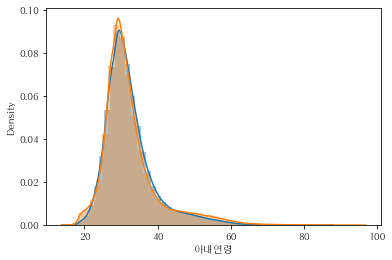

In [21]:
sns.distplot(df_from_2014_to_2021[df_from_2014_to_2021['강혼여부'] == 1]['아내연령'])
sns.distplot(df_from_2014_to_2021[df_from_2014_to_2021['강혼여부'] == 0]['아내연령'])
plt.show()

In [22]:
a = df_from_2014_to_2021[df_from_2014_to_2021['남편국제결혼여부'] ==1].groupby('강혼여부')['남편국제결혼여부'].count()
b = df_from_2014_to_2021[df_from_2014_to_2021['남편국제결혼여부'] ==0].groupby('강혼여부')['남편국제결혼여부'].count()
c = df_from_2014_to_2021.groupby('강혼여부')['남편국제결혼여부'].mean()
d = pd.merge(a,b,on= '강혼여부')
d = pd.merge(c,d,on= '강혼여부')

d

,남편국제결혼여부,남편국제결혼여부_x,남편국제결혼여부_y
강혼여부,,,
0.00000,0.01981,25579,1265850
1.00000,0.01933,5248,266306


In [23]:
a = df_from_2014_to_2021[df_from_2014_to_2021['아내국제결혼여부'] ==1].groupby('강혼여부')['아내국제결혼여부'].count()
b = df_from_2014_to_2021[df_from_2014_to_2021['아내국제결혼여부'] ==0].groupby('강혼여부')['아내국제결혼여부'].count()
c = df_from_2014_to_2021.groupby('강혼여부')['아내국제결혼여부'].mean()
d = pd.merge(a,b,on= '강혼여부')
d = pd.merge(c,d,on= '강혼여부')
d

,아내국제결혼여부,아내국제결혼여부_x,아내국제결혼여부_y
강혼여부,,,
0.00000,0.05835,75350,1216079
1.00000,0.06075,16496,255058


In [24]:
a = df_from_2014_to_2021[df_from_2014_to_2021['아내국제결혼여부'] ==1].groupby('강혼여부')['아내국제결혼여부'].count()
b = df_from_2014_to_2021[df_from_2014_to_2021['아내국제결혼여부'] ==0].groupby('강혼여부')['아내국제결혼여부'].count()
c = df_from_2014_to_2021.groupby('강혼여부')['아내국제결혼여부'].mean()
d = pd.merge(a,b,on= '강혼여부')
d = pd.merge(c,d,on= '강혼여부')
d

,아내국제결혼여부,아내국제결혼여부_x,아내국제결혼여부_y
강혼여부,,,
0.00000,0.05835,75350,1216079
1.00000,0.06075,16496,255058


In [25]:
a = df_from_2014_to_2021[df_from_2014_to_2021['아내국제결혼여부'] ==1].groupby('강혼여부')['아내국제결혼여부'].count()
b = df_from_2014_to_2021[df_from_2014_to_2021['아내국제결혼여부'] ==0].groupby('강혼여부')['아내국제결혼여부'].count()
c = df_from_2014_to_2021.groupby('강혼여부')['아내국제결혼여부'].mean()
d = pd.merge(a,b,on= '강혼여부')
d = pd.merge(c,d,on= '강혼여부')
d

,아내국제결혼여부,아내국제결혼여부_x,아내국제결혼여부_y
강혼여부,,,
0.00000,0.05835,75350,1216079
1.00000,0.06075,16496,255058


In [26]:
a = df_from_2014_to_2021[df_from_2014_to_2021['아내국제결혼여부'] ==1].groupby('강혼여부')['아내국제결혼여부'].count()
b = df_from_2014_to_2021[df_from_2014_to_2021['아내국제결혼여부'] ==0].groupby('강혼여부')['아내국제결혼여부'].count()
c = df_from_2014_to_2021.groupby('강혼여부')['아내국제결혼여부'].mean()
d = pd.merge(a,b,on= '강혼여부')
d = pd.merge(c,d,on= '강혼여부')
d

,아내국제결혼여부,아내국제결혼여부_x,아내국제결혼여부_y
강혼여부,,,
0.00000,0.05835,75350,1216079
1.00000,0.06075,16496,255058


In [27]:
a = df_from_2014_to_2021[df_from_2014_to_2021['소득차범주'] == 1].groupby('강혼여부')['소득차범주'].count()
b = df_from_2014_to_2021[df_from_2014_to_2021['소득차범주'] == 2].groupby('강혼여부')['소득차범주'].count()
c = df_from_2014_to_2021[df_from_2014_to_2021['소득차범주'] == 3].groupby('강혼여부')['소득차범주'].count()

d = pd.merge(a, b, on="강혼여부")
d = pd.merge(d, c, on="강혼여부")

d



,소득차범주_x,소득차범주_y,소득차범주
강혼여부,,,
0.00000,41345,30355,1219729
1.00000,12433,5778,253343


In [28]:
for e in df_from_2014_to_2021.columns:
    print(e)

신고연도
신고월
신고일
남편지역코드
아내지역코드
실제결혼연도
실제결혼월
남편직업코드
아내직업코드
남편교육코드
아내교육코드
남편결혼코드
아내결혼코드
남편연령
아내연령
남편국적구분코드
남편국적코드
아내국적구분코드
아내국적코드
남편소득수준
아내소득수준
남편출생년도
아내출생년도
강혼여부이전기준
강혼여부
동갑혼여부
연하혼여부
아내대도시여부
남편대도시여부
남편수도권여부
아내수도권여부
아내재혼여부
남편재혼여부
결혼종류차이여부
동질혼여부
승혼여부
소득차
소득차범주
아내연령제곱
남편연령제곱
아내무직여부
남편무직여부
동일지역여부
아내중졸여부
남편중졸여부
아내고졸여부
남편고졸여부
아내대졸여부
남편대졸여부
남편대학원졸여부
아내대학원졸여부
아내국제결혼여부
남편국제결혼여부
15년여부
16년여부
17년여부
18년여부
19년여부
20년여부
21년여부
코로나여부
아내코호트
1985 to 1990 (아내)
1990 to 1995 (아내)
1995 to 2000 (아내)
1975 to 1980 (아내)
1970 to 1975 (아내) (아내)
1980 to 1985 (아내)
1970 to 1975 (아내)
1995 to 2000 (아내) (아내)
남편코호트
1980 to 1985 (남편)
1985 to 1990 (남편)
1995 to 2000 (남편)
1990 to 1995 (남편)
1970 to 1975 (남편)
1975 to 1980 (남편)
1970 to 1975 (남편) (남편)
1995 to 2000 (남편) (남편)
시점1
시점2
시점3
시점4


# 강혼 요약


In [29]:
rows = ['소득차','남편수도권여부','아내수도권여부','아내고졸여부',
'동일지역여부','남편재혼여부','아내연령','아내국제결혼여부','남편국제결혼여부',
'15년여부','16년여부','17년여부','18년여부','19년여부','20년여부','21년여부']

newDf = pd.DataFrame(rows)

newDf.columns = ['열이름']
newDf.set_index('열이름', inplace= True)

for col in newDf.index.unique():
    newDf.loc[col, '평균'] = df_from_2014_to_2021[col].mean()
    newDf.loc[col, '중앙값'] = df_from_2014_to_2021[col].median()
    newDf.loc[col, '표준편차'] = df_from_2014_to_2021[col].std()

In [30]:
newDf

,평균,중앙값,표준편차
열이름,,,
소득차,-2395.09264,-1875.00000,2304.66202
남편수도권여부,0.51260,1.00000,0.49984
아내수도권여부,0.50243,1.00000,0.49999
아내고졸여부,0.24161,0.00000,0.42806
동일지역여부,0.72365,1.00000,0.44719
남편재혼여부,0.13023,0.00000,0.33656
아내연령,32.34524,30.56900,7.63954
아내국제결혼여부,0.05876,0.00000,0.23518
남편국제결혼여부,0.01972,0.00000,0.13905
